In [103]:
from datasets import load_dataset

dataset = load_dataset('json', data_files={'train': 'train.jsonl','test':'validation.jsonl'})

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out() 

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)

In [106]:
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

In [107]:
X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()

y_train, y_test = dataset['train']['label'], dataset['test']['label']

In [108]:
from sklearn.model_selection import train_test_split

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [109]:
def get_params():
    return [2, 5, 10, 20], [2, 4, 6, 8], [5, 10, 20], [4, 6, 8]

In [110]:
import matplotlib.pyplot as plt
import numpy as np

def visual(results, method):
    n_estimators_list, max_depth_list, final_n_estimators, final_max_depth = get_params()
    
    plt.figure(figsize=(10, 6))
    
    for max_depth in max_depth_list:
        subset = [
            np.mean([r['accuracy'] for r in results 
                    if r['base_depth'] == max_depth and r['base_trees'] == n])
            for n in n_estimators_list
        ]
        plt.plot(n_estimators_list, subset, label=f'Макс. глубина = {max_depth}')
    
    plt.xlabel('Количество деревьев (базовые модели)')
    plt.ylabel('Accuracy')
    plt.title(f'Зависимость accuracy от параметров ({method})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np

def blend_predictions(base_models, meta_model, input_data):
    # Получаем предсказания базовых моделей
    base_predictions = np.column_stack([
        model.predict(input_data) for model in base_models
    ])
    return meta_model.predict(base_predictions)

def train_and_evaluate_ensemble():
    param_grid = generate_parameter_grid()
    evaluation_results = []
    
    for base_trees in param_grid['base_estimators']:
        for base_depth in param_grid['base_depth']:
            # Обучаем базовые модели
            base_models = []
            level_one_predictions = []
            
            for seed in range(10):  # 10 базовых моделей
                model = train_base_model(base_trees, base_depth, seed)
                base_models.append(model)
                level_one_predictions.append(
                    model.predict(X_train_1)
                )
            
            # Подготавливаем данные для мета-модели
            meta_features = np.column_stack(level_one_predictions)
            
            # Подбираем параметры мета-модели
            for meta_trees in param_grid['meta_estimators']:
                for meta_depth in param_grid['meta_depth']:
                    # Обучаем мета-модель
                    meta_model = train_meta_model(
                        meta_trees, 
                        meta_depth, 
                        meta_features, 
                        y_train_1
                    )
                    
                    # Получаем итоговые предсказания
                    final_predictions = blend_predictions(
                        base_models, 
                        meta_model, 
                        X_test
                    )
                    
                    # Оцениваем качество
                    accuracy = metrics.accuracy_score(y_test, final_predictions)
                    
                    # Сохраняем результаты
                    evaluation_results.append({
                        'base_trees': base_trees,
                        'base_depth': base_depth,
                        'meta_trees': meta_trees,
                        'meta_depth': meta_depth,
                        'accuracy': accuracy
                    })
                    
    return evaluation_results

def train_base_model(n_trees, depth, random_seed):
    model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=depth,
        random_state=random_seed
    )
    model.fit(X_train_0, y_train_0)
    return model

def train_meta_model(n_trees, depth, features, targets):
    model = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=depth,
        random_state=42
    )
    model.fit(features, targets)
    return model

def generate_parameter_grid():
    return {
        'base_estimators': get_params()[0],
        'base_depth': get_params()[1],
        'meta_estimators': get_params()[2],
        'meta_depth': get_params()[3]
    }

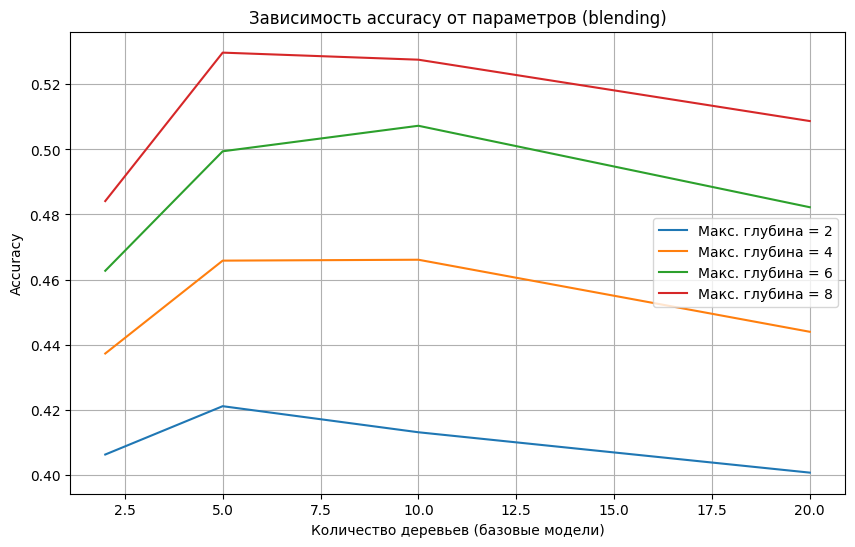

In [112]:
results = train_and_evaluate_ensemble()
visual(results, 'blending')

In [113]:
def train_and_evaluate_stacking():
    param_grid = generate_parameter_grid()
    evaluation_results = []
    kfold = KFold(n_splits=10, shuffle=True)
    
    # Преобразуем данные в numpy arrays
    X_train_array = np.array(X_train)
    y_train_array = np.array(y_train)
    
    for base_trees in param_grid['base_estimators']:
        for base_depth in param_grid['base_depth']:
            # Подготовка для стекинга
            fold_predictions = np.zeros((len(X_train_array), kfold.get_n_splits()))
            stacked_models = []
            
            # Обучение на фолдах
            for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train_array)):
                # Разделение данных
                fold_train_x = X_train_array[train_idx]
                fold_train_y = y_train_array[train_idx]
                fold_val_x = X_train_array[val_idx]
                
                # Обучение базовой модели
                base_model = train_base_model(
                    base_trees, 
                    base_depth, 
                    fold_idx
                )
                base_model.fit(fold_train_x, fold_train_y)
                
                # Сохранение модели и предсказаний
                stacked_models.append(base_model)
                fold_predictions[val_idx, fold_idx] = base_model.predict(fold_val_x)
            
            # Обучение мета-модели
            for meta_trees in param_grid['meta_estimators']:
                for meta_depth in param_grid['meta_depth']:
                    # Создание и обучение мета-модели
                    meta_model = train_meta_model(
                        meta_trees,
                        meta_depth,
                        fold_predictions,
                        y_train_array
                    )
                    
                    # Получение финальных предсказаний
                    final_predictions = stack_predictions(
                        stacked_models,
                        meta_model,
                        X_test
                    )
                    
                    # Оценка качества
                    accuracy = metrics.accuracy_score(y_test, final_predictions)
                    
                    # Сохранение результатов
                    evaluation_results.append({
                        'base_trees': base_trees,
                        'base_depth': base_depth,
                        'meta_trees': meta_trees,
                        'meta_depth': meta_depth,
                        'accuracy': accuracy
                    })
    
    return evaluation_results


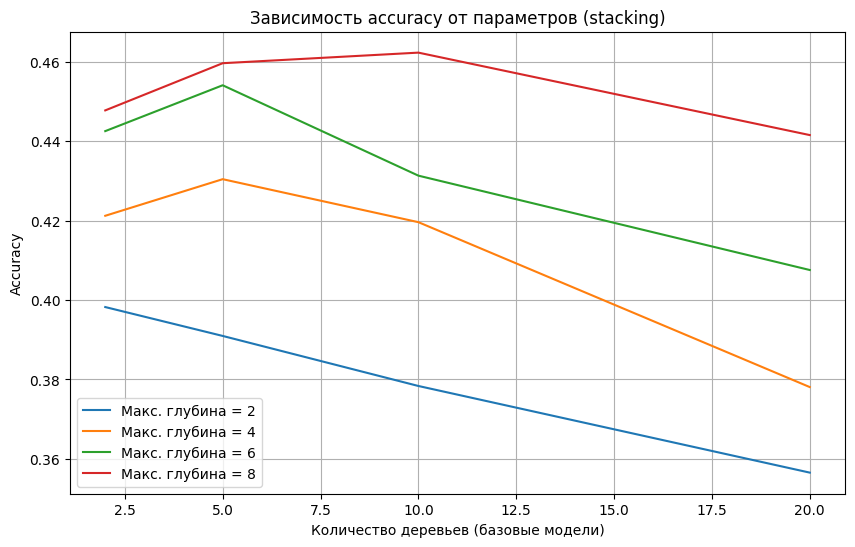

In [114]:
# Получение результатов
results = train_and_evaluate_stacking()

# Визуализация
visual(results, 'stacking')
